# 目標-模擬跨售：
- 本專案目標是建立跨售用之共用型顧客特徵向量，但是目前僅使用了信用卡產品線之交易與顧客資料，因此希望透過分析與觀察本資料，進行適當的資料切割，找出信用卡消費資料中潛在的跨售樣態，以模擬跨售的業務命題。具體而言，就是要找出兩類信用卡消費購買的產品，並看此兩類產品的顧客重疊與不重複的狀況，思考是否可以把Ａ類的產品推給Ｂ產品的顧客，或是反過來。此兩類產品重複的顧客之資料，可以作為驗證跨售成效之用，純消費某一類產品的顧客，則作為訓練用資料。

In [1]:
import os
import numpy as np
from time import time 
import pandas as pd
import matplotlib.pylab as plt
sample_path = '../data'
chid_file = os.path.join(sample_path, 'sample_chid.txt')
chid_dict_file = os.path.join(sample_path, 'sample_idx_map.npy')
cdtx_file = os.path.join(sample_path, 'sample_zip_if_cca_cdtx0001_hist.csv')
cust_f_file = os.path.join(sample_path, 'sample_zip_if_cca_cust_f.csv')


In [2]:
def load_chid_dict():
    chid_array = np.loadtxt(chid_file, dtype=np.str)
    chid_dict = np.load(chid_dict_file, allow_pickle=True).item()
    for i in range(len(chid_array)):
        assert chid_dict[chid_array[i]] == i
    return chid_dict

def load_cdtx():
    t0 = time()
    df_cdtx = pd.read_csv(cdtx_file, skipinitialspace=True)
    # df_cdtx.csmdt.apply(lambda x: x[:-len('T00:00:00.000Z')])
    df_cdtx.sort_values(by=['csmdt', 'chid'], inplace=True, ignore_index=True)
    # df_cdtx.objam = df_cdtx.objam.astype(np.int64)
    print('loading time:', time() - t0)
    # checking
    chid_dict = load_chid_dict()
    assert len(set(df_cdtx.chid) - set(chid_dict.keys())) == 0 \
        and len(set(chid_dict.keys()) - set(df_cdtx.chid)) == 0
    assert type(df_cdtx.objam[0]) == np.int64
    assert len(df_cdtx.csmdt[0]) == 10
    return df_cdtx

def load_cust_f():
    t0 = time()
    df_cust_f = pd.read_csv(cust_f_file, skipinitialspace=True)
    df_cust_f.sort_values(
        by=['data_dt', 'chid'],
        inplace=True,
        ignore_index=True
    )
    df_cust_f.drop_duplicates(ignore_index=True, inplace=True)
    print('loading time:', time() - t0)
    chid_dict = load_chid_dict()
    assert len(set(df_cust_f.chid) - set(chid_dict.keys())) == 0 \
        and len(set(chid_dict.keys()) - set(df_cust_f.chid)) == 0
    return df_cust_f


In [3]:
chid_dict = load_chid_dict()

In [4]:
df_cdtx = load_cdtx()

loading time: 58.10614061355591


# 交易檔欄位說明：
- bnsfg: 是否使用紅利點數
- bnspt: 使用紅利點數數量 
- chid:  顧客id 
- csmdt: 交易時間
- iterm: 使用分期付款
- mcc:   商戶類別代碼，是ISO 18245中為零售金融行業分配的4位數編碼，根據商戶類型（例如超市、酒店等）或商戶名稱（如3000為美聯航）。銀行卡組織（如中國銀聯、美國運通、萬事達、維薩）在商戶首次接入其收單服務時為商戶分配類別代碼。
- objam: 消費金額
- scity: 消費地區
- tcode: transaction code (?)
- hcefg: 支付方式註記

# 顧客檔欄位說明：
- data_ym: 資料處理時間
- monin: 薪水
- wrky: 工作年資
- first_mob: 往來月數
- data_dt: 資料觀測點
- masts: 婚姻
- educd: 學歷
- naty: 國籍
- trdtp: 行業別
- poscd: 職稱
- cuorg: 客戶來源 (?該不會是哪個分行) 
- cycam: 外部額度
- slam: 內部額度

# 各欄位的出現頻率與對應顧客數量 

In [20]:
def if_a_customer_use_the_product(group):
    #print(group.bnsfg)
    for bnsfg in group.bnsfg:
        #print(bnsfg)
        if bnsfg == 'Y':
            #print('Y')
            return 'Y'
    #print('N')
    return 'N'

## bnsfg: 是否使用紅利點數

### by 交易

<AxesSubplot:>

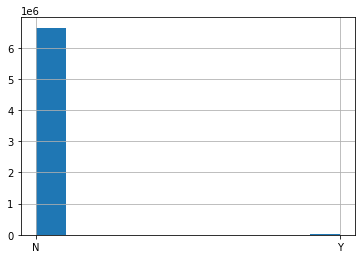

In [5]:
df_cdtx.bnsfg.hist()

### by 顧客

In [157]:
pd.DataFrame(df_cdtx[['bnsfg','chid']].groupby('chid').apply(
    if_a_customer_use_the_product
)).groupby(0).apply(lambda group: len(group) / len(df_cdtx.chid.unique()))

0
N    0.91084
Y    0.08916
dtype: float64

## bnspt: 使用紅利點數數量

### by 交易

<AxesSubplot:>

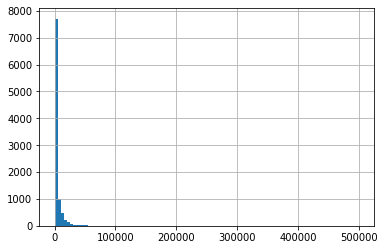

In [7]:
df_cdtx[df_cdtx.bnsfg == 'Y'].bnspt.hist(bins=100)

### by 顧客

<AxesSubplot:>

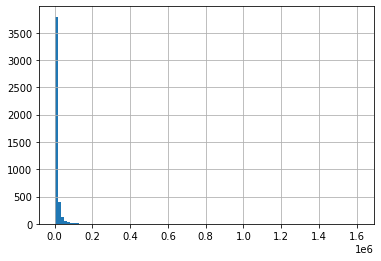

In [10]:
def sum_of_bnspt(group):
    return group.bnspt.sum()
df_cdtx[df_cdtx.bnsfg == 'Y'][['bnspt','chid']].groupby('chid').apply(sum_of_bnspt).hist(bins=100)

## iterm: 使用分期付款

### by 交易

<AxesSubplot:>

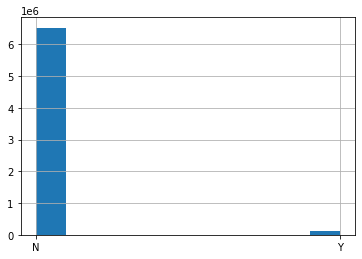

In [16]:
def zero_or_not_zero(x):
    if x > 0:
        return 'Y'
    else:
        return 'N'
df_cdtx.iterm.map(zero_or_not_zero).hist()

### by 顧客

In [158]:
def if_a_customer_use_iterm(x):
    for use_iterm in x.iterm.map(zero_or_not_zero):
        if use_iterm == 'Y':
            return 'Y'
    return 'N'

pd.DataFrame(df_cdtx[['iterm','chid']].groupby('chid').apply(if_a_customer_use_iterm)
            ).groupby(0).apply(lambda group: len(group) / len(df_cdtx.chid.unique()))

0
N    0.48862
Y    0.51138
dtype: float64

### by 交易

<AxesSubplot:>

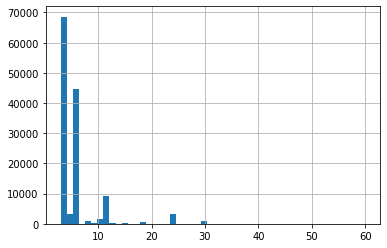

In [19]:
df_cdtx[df_cdtx.iterm>0].iterm.hist(bins=50)

## mcc: 商戶類別代碼

--- 

https://docs.checkout.com/resources/codes/merchant-category-codes


### by 交易

In [88]:
df_mcc_trancnt = pd.DataFrame(df_cdtx[['mcc']].groupby('mcc').apply(lambda group: len(group)))

df_mcc_trancnt.columns = ['trans_cnt']
df_mcc_trancnt.sort_values('trans_cnt',ascending = False, inplace = True)

df_mcc_trancnt.head()

,trans_cnt
mcc,
5411,890305
5311,531435
5541,465529
MRT5,415765
5812,341232


### by 顧客

In [89]:
def count_chid(group):
    return len(group.chid.unique())
df_mcc_chid_cnt = df_cdtx[['mcc','chid']].groupby('mcc').apply(count_chid)
df_mcc_chid_cnt.sort_values(ascending=False,inplace=True)
df_mcc_chid_cnt.head()

mcc
5411    37005
5311    35317
5812    29641
5399    24996
5541    24584
dtype: int64

### merge plot 

In [69]:
df_mcc_freq = df_mcc_trancnt.merge(
    pd.DataFrame(df_mcc_chid_cnt), 
    how='left',
    left_on='mcc',
    right_on = 'mcc')

In [72]:
df_mcc_freq.columns = ['trans_cnt','chid_cnt']

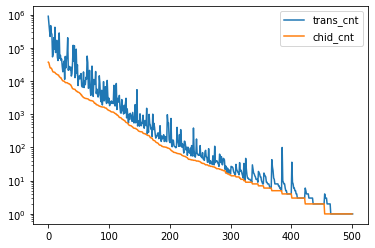

In [118]:
df_mcc_freq.sort_values(['chid_cnt','trans_cnt'],inplace=True,ascending=False)
plt.plot(df_mcc_freq.trans_cnt.tolist(),label='trans_cnt')
plt.plot(df_mcc_freq.chid_cnt.tolist(),label='chid_cnt')
plt.yscale('log')
plt.legend()
plt.show()

### scity: 消費地區

### by 交易

In [91]:
df_scity_trancnt = pd.DataFrame(df_cdtx[['scity']].groupby('scity').apply(lambda group: len(group)))

df_scity_trancnt.columns = ['trans_cnt']
df_scity_trancnt.sort_values('trans_cnt',ascending = False, inplace = True)

df_scity_trancnt.head(20)

,trans_cnt
scity,
TAIPEI,2093662
TAIPEI CITY,403311
TAICHUNG,374963
KAOHSIUNG,269840
TAOYUAN,254714
TAINAN,167094
HSINCHU,117386
Taipei City,109920
NEW TAIPEI CI,103715


### by 顧客

In [94]:
def count_chid(group):
    return len(group.chid.unique())
df_scity_chid_cnt = pd.DataFrame(df_cdtx[['scity','chid']].groupby('scity').apply(count_chid))
df_scity_chid_cnt.columns = ['chid_cnt']
df_scity_chid_cnt.sort_values('chid_cnt',ascending=False, inplace=True)
df_scity_chid_cnt.head()

,chid_cnt
scity,
TAIPEI,43451
TAIPEI CITY,33836
TAICHUNG,20513
Taipei City,17261
TAOYUAN,15692


In [95]:
df_scity_freq = df_scity_trancnt.merge(
    pd.DataFrame(df_scity_chid_cnt), 
    how='left',
    left_on='scity',
    right_on = 'scity')

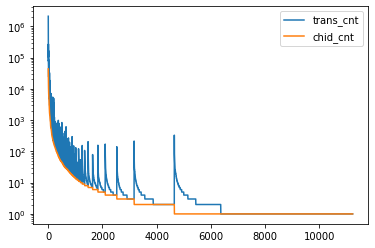

In [116]:
# df_scity_freq.sort_values('trans_cnt',inplace=True,ascending=False)
df_scity_freq.sort_values(['chid_cnt','trans_cnt'],inplace=True,ascending=False)
plt.plot(df_scity_freq.trans_cnt.tolist(),label='trans_cnt')
plt.plot(df_scity_freq.chid_cnt.tolist(),label='chid_cnt')
plt.yscale('log')
plt.legend()
plt.show()

In [131]:
print('percentage of transaction with HCE:', 
      round(sum(~pd.isna(df_cdtx.hcefg)) / len(df_cdtx) * 100,2),
      '%'
     )

percentage of transaction without HCE: 4.89 %


## HCE

In [149]:
df_chid_with_hce = pd.concat([pd.DataFrame((~pd.isna(df_cdtx.hcefg)).map(int)),df_cdtx.chid],axis=1)

df_chid_with_hce.groupby('hcefg').apply(lambda group: len(group)/len(df_chid_with_hce))

hcefg
0    0.951072
1    0.048928
dtype: float64

In [150]:
print(
    'rate of chid with HCE transaction:', 
    df_chid_with_hce.groupby('hcefg').apply(
        lambda group: len(group.chid.unique()) ).iloc[1] / len(
        df_cdtx.chid.unique()
    ))

rate of chid with HCE transaction: 0.17328


# 類產品線消費樣態： 

---

- Ａ：紅利點數使用之顧客，有使用點數多寡之分。使用紅利點數的顧客有8.92%。
   - 模擬跨售可能之效益：如果可以預測其他產品線的顧客其可能使用的紅利點數多寡/或消費的商家類型，並在適當的消費時機推薦顧客使用紅利點數，就有機會擴展使用紅利點數顧客數。（但是要知道紅利點數的源頭，也就是紅利所搭配的產品，並且在該產品被消費時，即時推薦顧客使用紅利點數，才能夠幫助到顧客。）
   - 顧客條件：紅利點數有使用 -> 專屬任務：紅利點數使用多寡、紅利點數所連結的店家或產品

- Ｂ：使用分期付款的顧客，有期數之分。使用分期的顧客佔51%。
   - 模擬跨售可能之效益：如果可以預測其他產品線顧客使用分期的期數/或消費之產品與金額類型，並在適當的時機推薦顧客使用分期付款，將有機會擴展使用分期的顧客之比例。
   - 顧客條件：有進行分期付款 -> 專屬任務：分期付款期數、分期付款所連結的店家或產品

- Ｄs：mcc有很多類型，但是有些類型消費顧客比例很低，也就是說有很大的提升的空間。
   - 模擬跨售可能之效益: 我們可以試著預測沒有使用某類mcc的顧客其可能消費的店家或商品（不確定能不能信用卡資料是否有細到有商品），藉此提升某類型商品之顧客消費數量。（或許更有價值的服務是提升某一店家的顧客消費數，這樣我們就可以和那家店合作，幫他們擴展客源）。
   - 顧客條件：有消費某mcc類別 -> 專屬任務：該類別所連結之店家 

- Ｅs：scity有很多地區，大部分的顧客都是在大城市消費（e.g., 台北、新北），某些二線城市消費顧客就是比較少，這或許和顧客的地域性有關。
   - 模擬跨售可能之效益: 如果可以預測平常沒有去這些二線城市的顧客他們可能在二線城市可能會做的消費，在他們去旅遊時，適時提供相應的店家優惠推薦，將有機會提高顧客的心佔率。
   - 顧客條件：有至某地區消費 -> 專屬任務：該地區之消費店家
   
* TODO：

- [ ] 加入stonc欄位進入考量，讓類產品線的消費樣態分析更完整，以使模擬跨售的實驗更完整。
- [ ] 搭配來進行跨售的產品線為何？


# 資料切割 I：

--- 
若考量希望把A產品線推薦給B產品線的顧客，我們要把純A產品線顧客(只有消費A產品線產品/沒有消費B產品線產品)挑出，作為來源顧客（Source Customer)；然後，把有消費A產品線，也有消費B產品線的顧客抓出來，作為目標顧客（Target Customer)，並隨機的篩選一部分的Target Customer，作為測試用顧客（Testing Customer)。在Training的時候，我們會綜合使用 1. Source Customer的Ａ產品線消費資料以及顧客之基本資訊作爲Source Dataset，以及 2. Target Customer非屬於Testing Customer的B產品線消費資料以及顧客之基本資訊。

p.s., 
1. Target Customer的Training Data在訓練時，不考慮A產品線的資料，因為
2. 之所以要選擇同時消費A產品線和B產品線的顧客作為Target Customer和測試資料，是因為我們希望Target 顧客之測試和訓練有共同的資料分佈，而也只有這個資料中，我們可以找到B產品線顧客中，A產品線消費的狀況作為Groud Truth。

In [62]:
from random import sample

def select_source_target_test_chid(A_criteria, B_criteria):
    pure_A_chid = set(df_cdtx[A_criteria].chid) - set(df_cdtx[B_criteria].chid) 
    source_chid = list(pure_A_chid)
    
    A_B_chid = set(df_cdtx[A_criteria].chid) & set(df_cdtx[B_criteria].chid)
    test_chid = sample(A_B_chid,k = int(0.2 * len(A_B_chid)))
    target_chid =  set(A_B_chid)- set(test_chid)

    print('# source chid:', len(source_chid))
    print('# target chid:', len(target_chid))
    print('# test chid:', len(test_chid))
    return source_chid, target_chid, test_chid

## 紅利服務推給分期用戶

In [63]:
A_criteria = df_cdtx.bnsfg == 'Y'
B_criteria = df_cdtx.iterm > 0 
source_chid, target_chid, test_chid = select_source_target_test_chid(A_criteria, B_criteria)

# source chid: 1303
# target chid: 2524
# test chid: 631


## 分期服務推給紅利用戶

In [64]:
A_criteria = df_cdtx.iterm > 0 
B_criteria = df_cdtx.bnsfg == 'Y'
source_chid, target_chid, test_chid = select_source_target_test_chid(A_criteria, B_criteria)

# source chid: 22414
# target chid: 2524
# test chid: 631


## MCC

In [68]:
def count_chid(group):
    return len(group.chid.unique())
df_mcc_chid_cnt = df_cdtx[['mcc','chid']].groupby('mcc').apply(count_chid)
df_mcc_chid_cnt.sort_values(ascending=False,inplace=True)
df_mcc_chid_cnt.head()

mcc
5411    37005
5311    35317
5812    29641
5399    24996
5541    24584
dtype: int64

## 紅利服務推給某mcc_code消費戶

In [72]:
for target_mcc in df_mcc_chid_cnt.index[:4]:
    print('target_mcc:', target_mcc)
    A_criteria = df_cdtx.bnsfg == 'Y'
    B_criteria = df_cdtx.mcc == target_mcc
    source_chid, target_chid, test_chid = select_source_target_test_chid(A_criteria, B_criteria)

target_mcc: 5411
# source chid: 970
# target chid: 2791
# test chid: 697
target_mcc: 5311
# source chid: 427
# target chid: 3225
# test chid: 806
target_mcc: 5812
# source chid: 1157
# target chid: 2641
# test chid: 660
target_mcc: 5399
# source chid: 1335
# target chid: 2499
# test chid: 624


## 分期服務推給某mcc_code消費戶

In [79]:
for target_mcc in df_mcc_chid_cnt.index[:20]:
    print('target_mcc:', target_mcc)
    A_criteria = df_cdtx.iterm >0
    B_criteria = df_cdtx.mcc == target_mcc
    source_chid, target_chid, test_chid = select_source_target_test_chid(A_criteria, B_criteria)

target_mcc: 5411
# source chid: 4994
# target chid: 16460
# test chid: 4115
target_mcc: 5311
# source chid: 4030
# target chid: 17232
# test chid: 4307
target_mcc: 5812
# source chid: 8347
# target chid: 13778
# test chid: 3444
target_mcc: 5399
# source chid: 9882
# target chid: 12550
# test chid: 3137
target_mcc: 5541
# source chid: 11612
# target chid: 11166
# test chid: 2791
target_mcc: 5499
# source chid: 10960
# target chid: 11688
# test chid: 2921
target_mcc: 6300
# source chid: 12433
# target chid: 10509
# test chid: 2627
target_mcc: 5732
# source chid: 11930
# target chid: 10912
# test chid: 2727
target_mcc: 5691
# source chid: 14034
# target chid: 9228
# test chid: 2307
target_mcc: 5331
# source chid: 13130
# target chid: 9952
# test chid: 2487
target_mcc: 7011
# source chid: 14940
# target chid: 8504
# test chid: 2125
target_mcc: MRT5
# source chid: 15295
# target chid: 8220
# test chid: 2054
target_mcc: 4722
# source chid: 15192
# target chid: 8302
# test chid: 2075
target_m

## 某mcc_code商店推給紅利用戶

In [73]:
for source_mcc in df_mcc_chid_cnt.index[:4]:
    print('source_mcc:', source_mcc)
    A_criteria = df_cdtx.mcc == source_mcc
    B_criteria = df_cdtx.bnsfg == 'Y'
    source_chid, target_chid, test_chid = select_source_target_test_chid(A_criteria, B_criteria)

target_mcc: 5411
# source chid: 33517
# target chid: 2791
# test chid: 697
target_mcc: 5311
# source chid: 31286
# target chid: 3225
# test chid: 806
target_mcc: 5812
# source chid: 26340
# target chid: 2641
# test chid: 660
target_mcc: 5399
# source chid: 21873
# target chid: 2499
# test chid: 624


## 某mcc_code商店推給分期用戶

In [81]:
for source_mcc in df_mcc_chid_cnt.index[:20]:
    print('source_mcc:', source_mcc)
    A_criteria = df_cdtx.mcc == source_mcc
    B_criteria = df_cdtx.iterm > 0 
    source_chid, target_chid, test_chid = select_source_target_test_chid(A_criteria, B_criteria)

source_mcc: 5411
# source chid: 16430
# target chid: 16460
# test chid: 4115
source_mcc: 5311
# source chid: 13778
# target chid: 17232
# test chid: 4307
source_mcc: 5812
# source chid: 12419
# target chid: 13778
# test chid: 3444
source_mcc: 5399
# source chid: 9309
# target chid: 12550
# test chid: 3137
source_mcc: 5541
# source chid: 10627
# target chid: 11166
# test chid: 2791
source_mcc: 5499
# source chid: 9877
# target chid: 11688
# test chid: 2921
source_mcc: 6300
# source chid: 9403
# target chid: 10509
# test chid: 2627
source_mcc: 5732
# source chid: 6495
# target chid: 10912
# test chid: 2727
source_mcc: 5691
# source chid: 7116
# target chid: 9228
# test chid: 2307
source_mcc: 5331
# source chid: 6072
# target chid: 9952
# test chid: 2487
source_mcc: 7011
# source chid: 7872
# target chid: 8504
# test chid: 2125
source_mcc: MRT5
# source chid: 7792
# target chid: 8220
# test chid: 2054
source_mcc: 4722
# source chid: 6545
# target chid: 8302
# test chid: 2075
source_mcc: 5

## 某mcc_code商店推給另一mcc_code商店

In [78]:
for source_mcc in df_mcc_chid_cnt.index[:20]:
    for target_mcc in df_mcc_chid_cnt.index[:20]:
        if source_mcc != target_mcc:
            print('source_mcc:', source_mcc)
            print('target_mcc:', target_mcc)
            A_criteria = df_cdtx.mcc == source_mcc
            B_criteria = df_cdtx.mcc == target_mcc
            source_chid, target_chid, test_chid = select_source_target_test_chid(A_criteria, B_criteria)

source_mcc: 5712
target_mcc: 5941
# source chid: 7875
# target chid: 6102
# test chid: 1525
source_mcc: 5712
target_mcc: 4112
# source chid: 8507
# target chid: 5596
# test chid: 1399
source_mcc: 5712
target_mcc: 5542
# source chid: 9677
# target chid: 4660
# test chid: 1165
source_mcc: 5712
target_mcc: 5811
# source chid: 8996
# target chid: 5205
# test chid: 1301
source_mcc: 5941
target_mcc: 5712
# source chid: 7533
# target chid: 6102
# test chid: 1525
source_mcc: 5941
target_mcc: 4112
# source chid: 8172
# target chid: 5591
# test chid: 1397
source_mcc: 5941
target_mcc: 5542
# source chid: 9570
# target chid: 4472
# test chid: 1118
source_mcc: 5941
target_mcc: 5811
# source chid: 9119
# target chid: 4833
# test chid: 1208
source_mcc: 4112
target_mcc: 5712
# source chid: 8112
# target chid: 5596
# test chid: 1399
source_mcc: 4112
target_mcc: 5941
# source chid: 8119
# target chid: 5591
# test chid: 1397
source_mcc: 4112
target_mcc: 5542
# source chid: 9679
# target chid: 4343
# test

## Scity

In [83]:
def count_chid(group):
    return len(group.chid.unique())
df_scity_chid_cnt = df_cdtx[['scity','chid']].groupby('scity').apply(count_chid)
df_scity_chid_cnt.sort_values(ascending=False,inplace=True)
df_scity_chid_cnt.head()

scity
TAIPEI         43451
TAIPEI CITY    33836
TAICHUNG       20513
Taipei City    17261
TAOYUAN        15692
dtype: int64

In [87]:
len(df_scity_chid_cnt.index.tolist())

11236

## 把分期服務推給某地區顧客

In [88]:
for target_scity in df_scity_chid_cnt.index[:20]:
    print('target_scity:', target_scity)
    A_criteria = df_cdtx.iterm >0
    B_criteria = df_cdtx.scity == target_scity
    source_chid, target_chid, test_chid = select_source_target_test_chid(A_criteria, B_criteria)

target_scity: TAIPEI
# source chid: 2336
# target chid: 18587
# test chid: 4646
target_scity: TAIPEI CITY
# source chid: 5285
# target chid: 16228
# test chid: 4056
target_scity: TAICHUNG
# source chid: 13470
# target chid: 9680
# test chid: 2419
target_scity: Taipei City
# source chid: 15347
# target chid: 8178
# test chid: 2044
target_scity: TAOYUAN
# source chid: 16484
# target chid: 7268
# test chid: 1817
target_scity: NEW TAIPEI CI
# source chid: 16427
# target chid: 7314
# test chid: 1828
target_scity: KAOHSIUNG
# source chid: 17045
# target chid: 6820
# test chid: 1704
target_scity: TAOYUAN CITY
# source chid: 17433
# target chid: 6509
# test chid: 1627
target_scity: TAICHUNG CITY
# source chid: 17299
# target chid: 6616
# test chid: 1654
target_scity: TAINAN
# source chid: 18894
# target chid: 5340
# test chid: 1335
target_scity: New Taipei Ci
# source chid: 18696
# target chid: 5499
# test chid: 1374
target_scity: KAOHSIUNG CIT
# source chid: 19353
# target chid: 4973
# test c

## 把某類的店推給某地區顧客

In [89]:
for source_mcc in df_mcc_chid_cnt.index[:20]:
    for target_scity in df_scity_chid_cnt.index[:20]:
        print('source_mcc:', source_mcc)
        print('target_scity:', target_scity)
        A_criteria = df_cdtx.mcc == source_mcc
        B_criteria = df_cdtx.scity == target_scity
        source_chid, target_chid, test_chid = select_source_target_test_chid(A_criteria, B_criteria)

source_mcc: 5411
target_scity: TAIPEI
# source chid: 4000
# target chid: 26404
# test chid: 6601
source_mcc: 5411
target_scity: TAIPEI CITY
# source chid: 10391
# target chid: 21292
# test chid: 5322
source_mcc: 5411
target_scity: TAICHUNG
# source chid: 20304
# target chid: 13361
# test chid: 3340
source_mcc: 5411
target_scity: Taipei City
# source chid: 22732
# target chid: 11419
# test chid: 2854
source_mcc: 5411
target_scity: TAOYUAN
# source chid: 23570
# target chid: 10748
# test chid: 2687
source_mcc: 5411
target_scity: NEW TAIPEI CI
# source chid: 24345
# target chid: 10128
# test chid: 2532
source_mcc: 5411
target_scity: KAOHSIUNG
# source chid: 24975
# target chid: 9624
# test chid: 2406
source_mcc: 5411
target_scity: TAOYUAN CITY
# source chid: 25728
# target chid: 9022
# test chid: 2255
source_mcc: 5411
target_scity: TAICHUNG CITY
# source chid: 26686
# target chid: 8256
# test chid: 2063
source_mcc: 5411
target_scity: TAINAN
# source chid: 27557
# target chid: 7559
# test 

# source chid: 11247
# target chid: 10670
# test chid: 2667
source_mcc: 5541
target_scity: Taipei City
# source chid: 14605
# target chid: 7984
# test chid: 1995
source_mcc: 5541
target_scity: TAOYUAN
# source chid: 14441
# target chid: 8115
# test chid: 2028
source_mcc: 5541
target_scity: NEW TAIPEI CI
# source chid: 16140
# target chid: 6756
# test chid: 1688
source_mcc: 5541
target_scity: KAOHSIUNG
# source chid: 15446
# target chid: 7311
# test chid: 1827
source_mcc: 5541
target_scity: TAOYUAN CITY
# source chid: 16158
# target chid: 6741
# test chid: 1685
source_mcc: 5541
target_scity: TAICHUNG CITY
# source chid: 16556
# target chid: 6423
# test chid: 1605
source_mcc: 5541
target_scity: TAINAN
# source chid: 16645
# target chid: 6352
# test chid: 1587
source_mcc: 5541
target_scity: New Taipei Ci
# source chid: 18006
# target chid: 5263
# test chid: 1315
source_mcc: 5541
target_scity: KAOHSIUNG CIT
# source chid: 18425
# target chid: 4928
# test chid: 1231
source_mcc: 5541
target_

# source chid: 10651
# target chid: 6400
# test chid: 1600
source_mcc: 5691
target_scity: NEW TAIPEI CI
# source chid: 10552
# target chid: 6480
# test chid: 1619
source_mcc: 5691
target_scity: KAOHSIUNG
# source chid: 11830
# target chid: 5457
# test chid: 1364
source_mcc: 5691
target_scity: TAOYUAN CITY
# source chid: 11305
# target chid: 5877
# test chid: 1469
source_mcc: 5691
target_scity: TAICHUNG CITY
# source chid: 12044
# target chid: 5286
# test chid: 1321
source_mcc: 5691
target_scity: TAINAN
# source chid: 13035
# target chid: 4493
# test chid: 1123
source_mcc: 5691
target_scity: New Taipei Ci
# source chid: 12472
# target chid: 4944
# test chid: 1235
source_mcc: 5691
target_scity: KAOHSIUNG CIT
# source chid: 13815
# target chid: 3869
# test chid: 967
source_mcc: 5691
target_scity: HSINCHU
# source chid: 13675
# target chid: 3981
# test chid: 995
source_mcc: 5691
target_scity: Taipei
# source chid: 13626
# target chid: 4020
# test chid: 1005
source_mcc: 5691
target_scity: T

KeyboardInterrupt: 

In [41]:
print(len(source_chid))

1303


In [39]:
target_chid = set(df_cdtx[df_cdtx.bnsfg == 'Y'].chid) | set(df_cdtx[df_cdtx.iterm > 0].chid)

In [42]:
print(len(target_chid))

26872


In [31]:
source_dataset.

,bnsfg,bnspt,chid,csmdt,iterm,mcc,objam,scity,tcode,hcefg
166,Y,2000,/SN9nzW/E/Z6b3jGdvUyog==,2018-01-01,0,5331,6755,TAIPEI CITY,5,NaN
746,Y,3000,4hxpIg3Y5IFKq4nPF0G8aQ==,2018-01-01,0,4722,119080,NaN,5,NaN
1747,Y,9000,Cmxlxa0b5dMlFyUrg5fVIQ==,2018-01-01,0,5311,126828,NaN,5,NaN
2885,Y,26000,LVGZkad8i7vllnlRWVDz+w==,2018-01-01,0,4722,419900,TAIPEI,5,NaN
5565,Y,3000,iUEqqGFKcf777H4TkNwHEQ==,2018-01-01,0,5311,11606,TAIPEI,5,NaN
...,...,...,...,...,...,...,...,...,...,...
6649650,Y,1000,X2f5SmkvXzw31ZOFhBVCFA==,2020-01-31,0,5311,30659,TAIPEI,5,NaN
6651153,Y,6000,fxgeOPBYR99wlsdvutWELg==,2020-01-31,0,5331,7795,TAIPEI CITY,5,NaN
6653743,Y,200,snkg9NWKLLvJyD2IkKJDiQ==,2020-01-31,0,7538,18554,TAICHUNG,5,NaN
6654533,Y,940,xTlyt4SlgoSwqLER8CZ7Wg==,2020-01-31,0,5499,489,TAIPEI,5,Q
